Here are five ideas to explore using my phone’s sensors:
1.	Sound Level Analysis with the Mic: I wanted data to calculate the average decibel level and visualize the noise variations throughout the day by measuring the ambient noise levels in different environments (e.g., quiet room, noisy room, etc.) over time.
2.	Light Intensity Measurement with the Light Sensor.
3.	Ambient Temperature and Humidity Correlation with Sound Propagation: Use the phone’s microphone to record sound at different frequencies in various environments while in parallel trying ambient temperature and humidity data using an external sensor or an app that provides weather data.
4.	Traffic Flow Analysis Using Video and Accelerometer Data: Use the phone’s camera to record video and to try to correlate the number of vehicles in the video with the vibration intensity recorded by the accelerometer to estimate traffic flow.
5.	Analyzing photos of tree leaves to check their health and greenness: Used the phone’s camera to take photos of a plant's leaves. After collecting the images, I analyzed the data by measuring differences in the plant’s leaf size, and color intensity.

As clearly stated, I chose to work on the fifth idea.

Here is how I started collecting data.

I took a white A4 paper, put it behind leaves, and took photos.
Adding a white A4 paper behind the leaves was necessary because if the backgrounds were different for each leaf, this would not lead to analyzing the greenness only but also the background colors.
So this is what I did,
1. Take a picture of a very good green leaf from the tree. Make that green color the standard color for others.
2. Take pictures of other leaves and compare greenness and plant health index.

I now have photos of leaves from the same tree. One of them being ideal green, and the rest are less and less green reaching almost full brown.
Below is the Python code that can analyze those photos of the leaves and identify their greenness. I also analyzed the plant health index, and it was clear by the results that greenness and health index are proportional which is logic.




In [ ]:
from google.colab import files

uploaded = files.upload()

Saving before last.jpg to before last.jpg
Saving first.jpg to first.jpg
Saving last.jpg to last.jpg
Saving second.jpg to second.jpg
Saving third.jpg to third.jpg


The five leaf photos above are my data. Now I will study their greenness, roughness and health index, while comparing them all. The results should be In the order that I named the photos.

In [ ]:
import os
os.listdir('/content/')


['.config',
 'second.jpg',
 'third.jpg',
 'last.jpg',
 'before last.jpg',
 'first.jpg',
 'sample_data']

Third
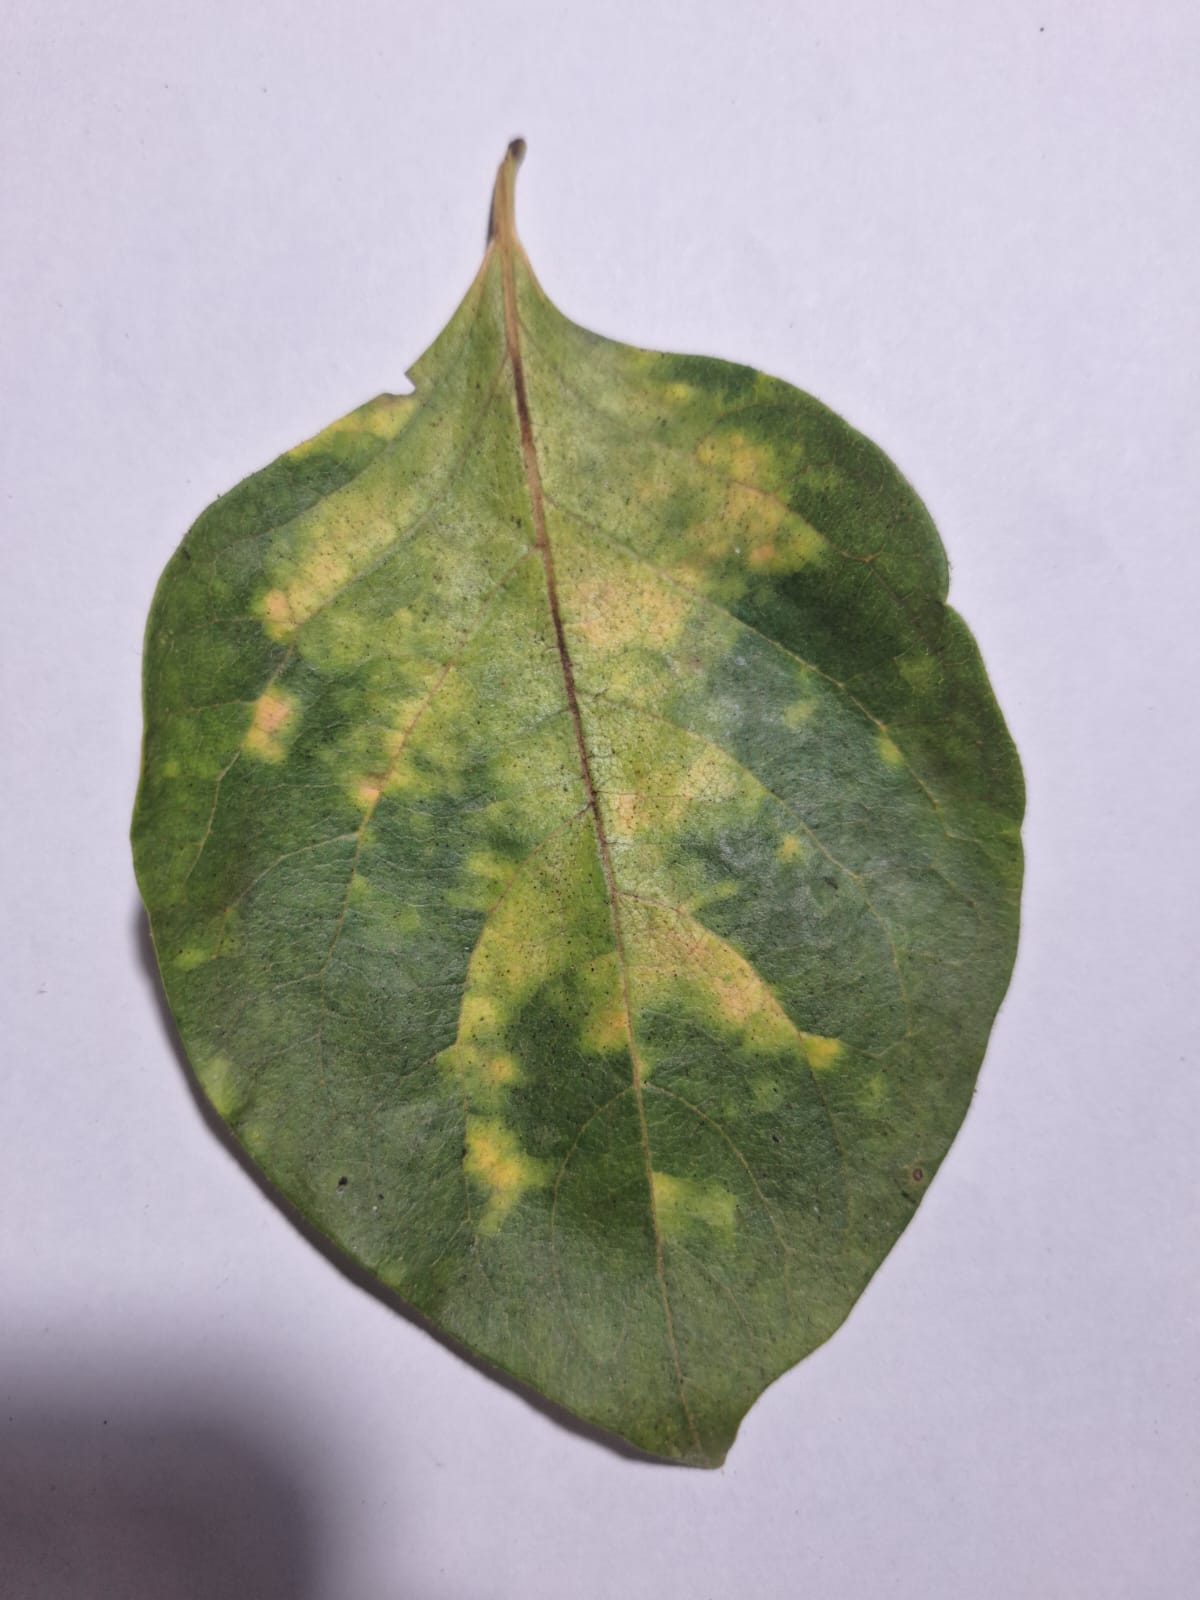
Second
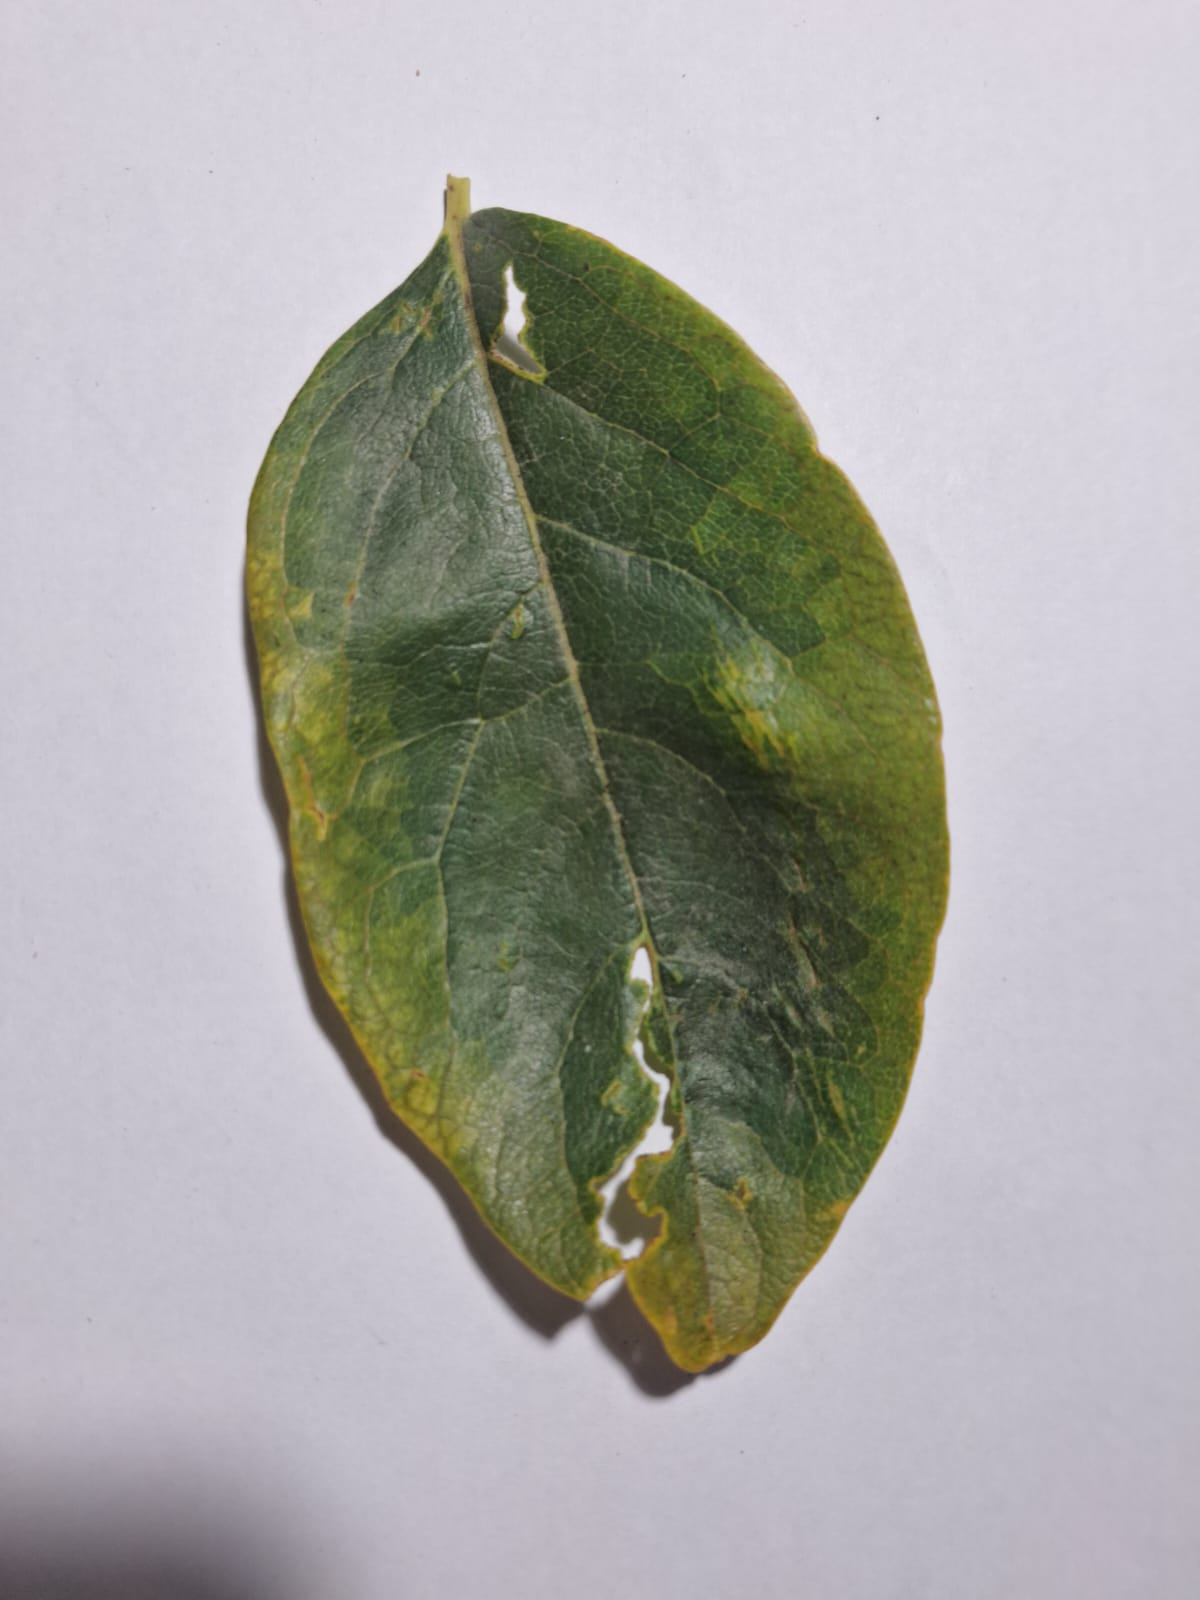
Last
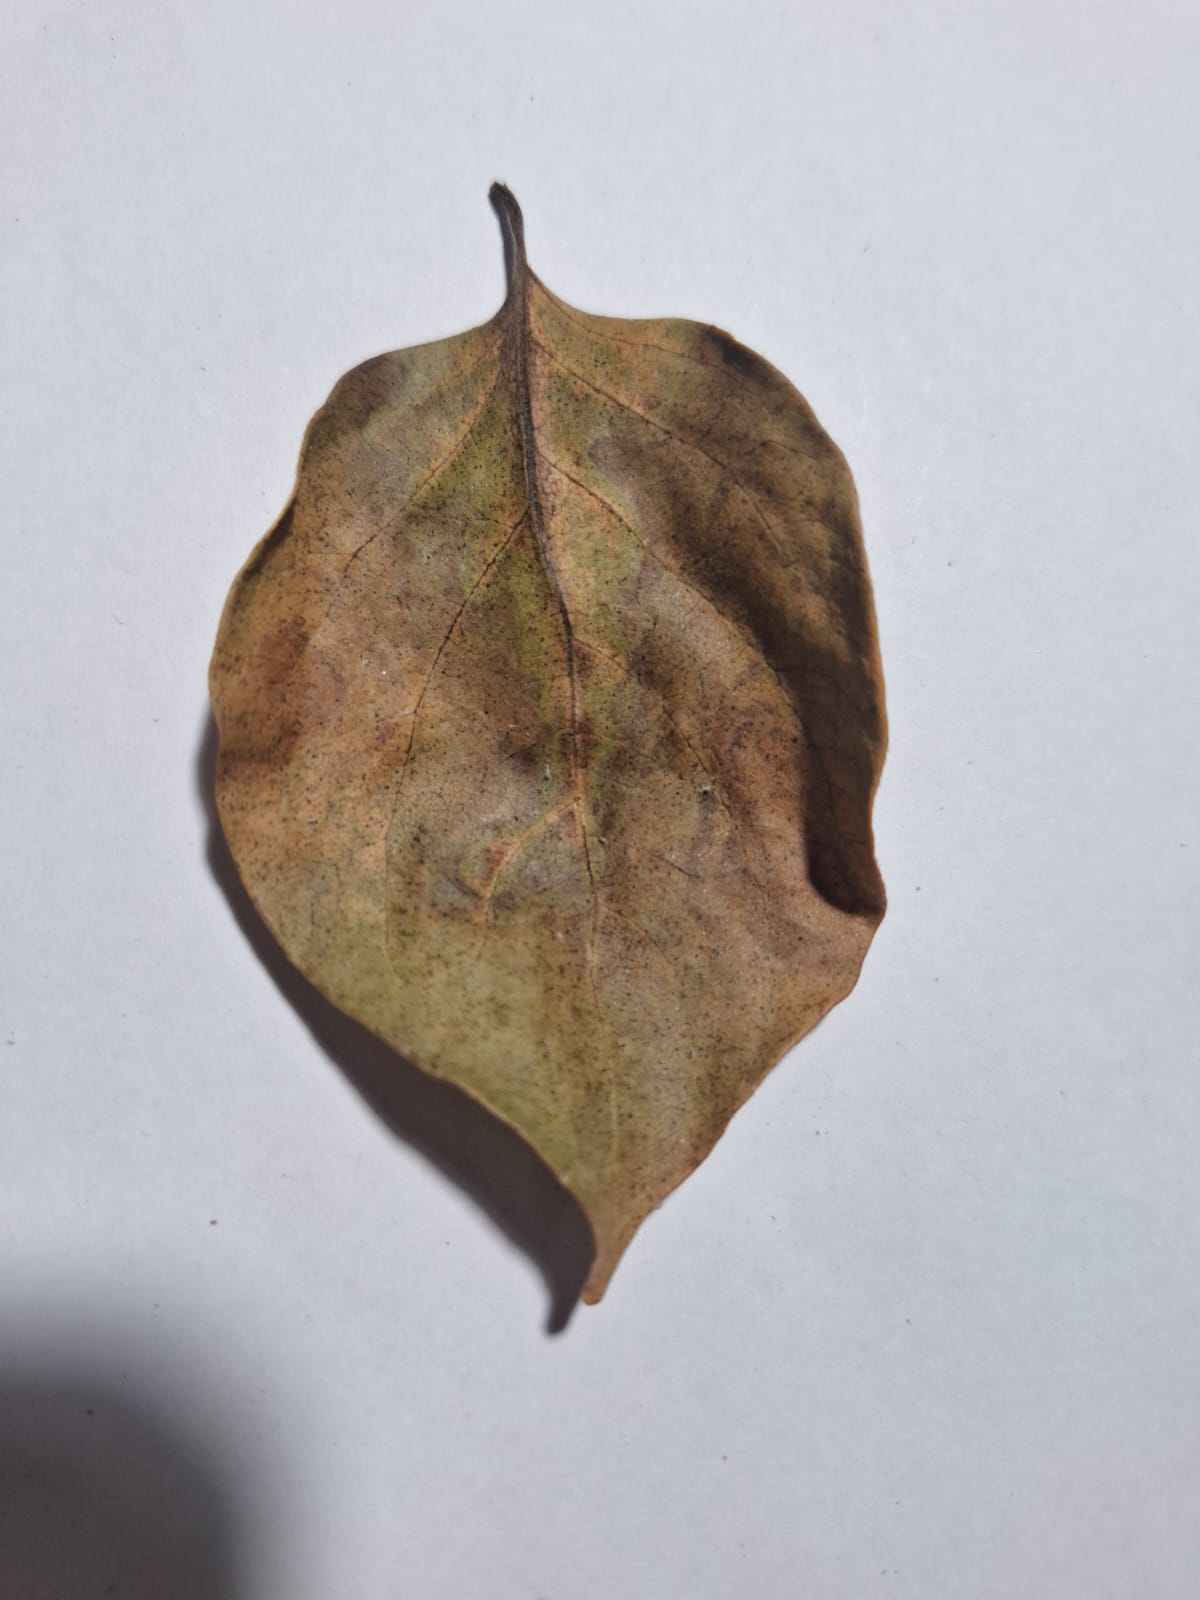
First
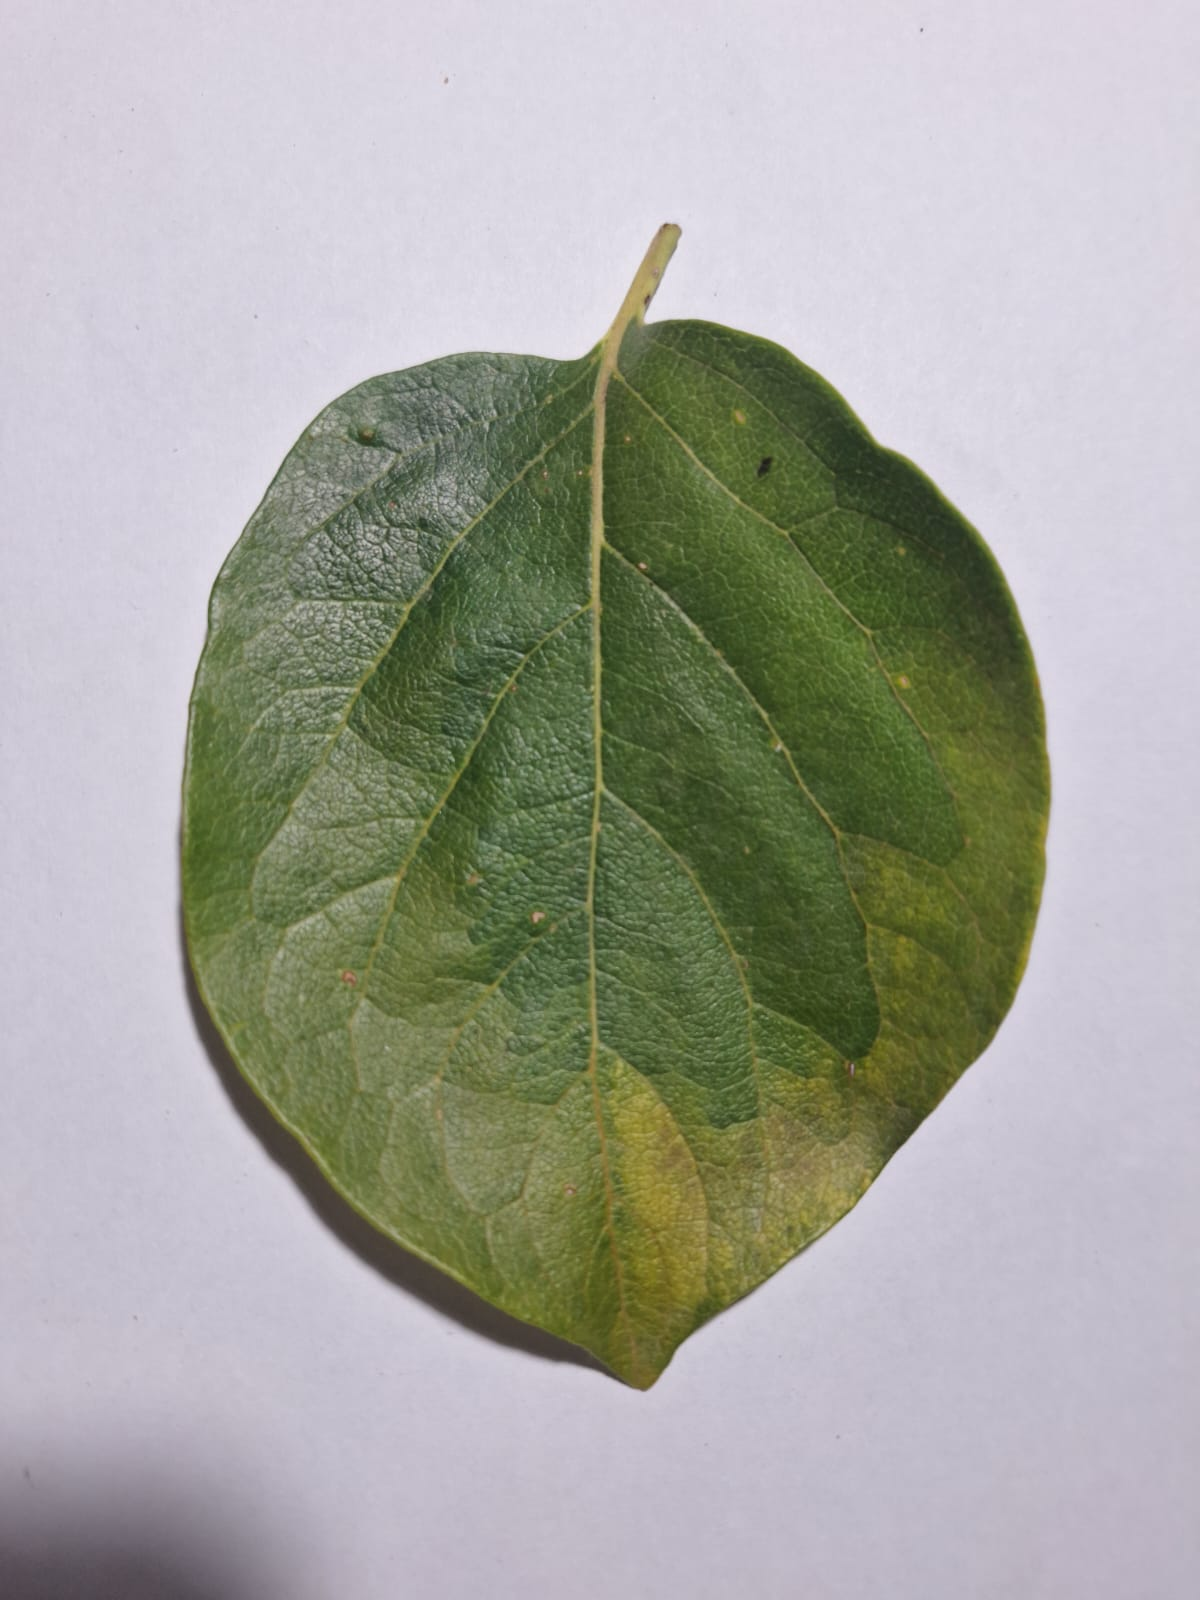
Before Last
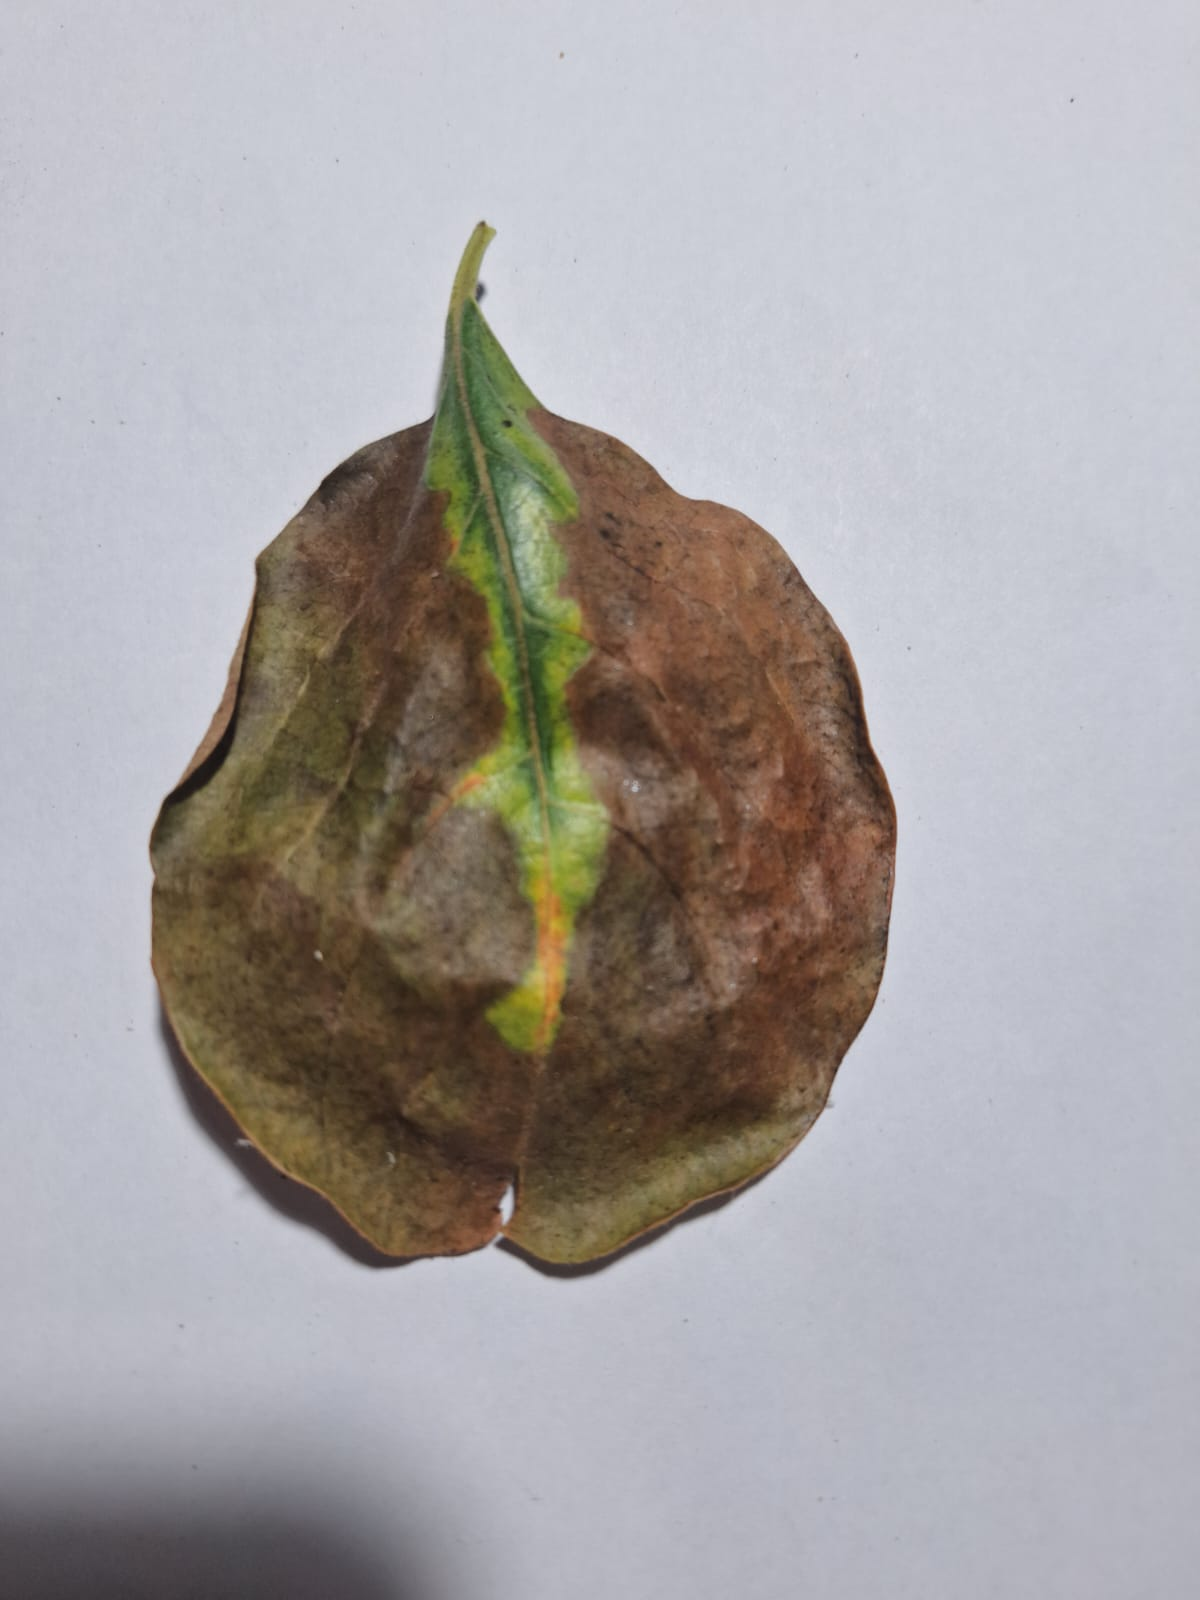

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_leaf_size(mask):
    #Compute leaf size from the total image
    leaf_area = np.sum(mask > 0)
    total_area = mask.shape[0] * mask.shape[1]
    return leaf_area / total_area

def compute_leaf_roughness(image):
    #Compute leaf roughness by taking into account the edges
    #Using opencv
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, threshold1=30, threshold2=100)
    roughness = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
    return roughness

def compute_greenness(image_path):

    # Read the image using opencv
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Unable to load image '{image_path}'. Skipping.")
        return None
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range for green color
    lower_green = np.array([0, 0, 0])
    upper_green = np.array([85, 255, 255])

    green_mask = cv2.inRange(image_hsv, lower_green, upper_green)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(float)
    green_only = cv2.bitwise_and(image_rgb, image_rgb, mask=green_mask)

    # Extract the channels
    R = green_only[:, :, 0]
    G = green_only[:, :, 1]
    B = green_only[:, :, 2]

    # Compute the greenness of the leaf
    epsilon = 1e-6
    denominator = R + G + B + epsilon
    greenness = G / denominator

    # Calculate the average greenness across the leaf (only green areas)
    green_area = np.sum(green_mask > 0)
    total_area = image.shape[0] * image.shape[1]
    avg_greenness = np.mean(greenness[green_mask > 0])
    green_area_ratio = green_area / total_area

    # Compute leaf size
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, leaf_mask = cv2.threshold(gray_image, 240, 255, cv2.THRESH_BINARY_INV)
    leaf_size = compute_leaf_size(leaf_mask)

    # Compute leaf roughness
    leaf_roughness = compute_leaf_roughness(image)

    return avg_greenness, green_area_ratio, leaf_size, leaf_roughness

def analyze_leaves(directory):

    supported_formats = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(supported_formats)]

    if not image_files:
        print("No image files found in the specified directory.")
        return

    health_scores = {}

    print("Analyzing images...\n")

    for img in image_files:
        path = os.path.join(directory, img)
        result = compute_greenness(path)
        if result is not None:
            avg_greenness, green_area_ratio, leaf_size, leaf_roughness = result
            # Calculate Plant Health Index (PHI)
            PHI = 0.5 * avg_greenness + 0.3 * leaf_size + 0.2 * (1 - leaf_roughness)
            health_scores[img] = PHI
            print(f"Analyzed '{img}': plant health index = {PHI:.4f} (Greenness: {avg_greenness:.4f}, Size: {leaf_size:.4f}, Roughness: {leaf_roughness:.4f})")

    if not health_scores:
        print("No valid images were processed.")
        return

    # Identify the healthiest leaf image (highest PHI)
    healthiest_image = max(health_scores, key=health_scores.get)
    healthiest_score = health_scores[healthiest_image]

    print("\n=== Analysis Results ===")
    print(f"Healthiest Leaf: '{healthiest_image}' with a Plant Health Index (PHI) of {healthiest_score:.4f}")
    print("\nOther Leaves:")

    sorted_images = sorted(health_scores.items(), key=lambda x: x[1], reverse=True)

    for img, PHI in sorted_images:
        if img == healthiest_image:
            continue  # Skip the healthiest image
        relative_health = (PHI / healthiest_score) * 100
        print(f" - '{img}': Plant Health Index = {PHI:.4f} ({relative_health:.2f}% of healthiest leaf)")

    print("\nAnalysis complete.")

if __name__ == "__main__":
    # Example of processing the uploaded image directly
    directory = "/content/"  # Directory where your leaf images are stored

    if not os.path.isdir(directory):
        print(f"Error: The directory '{directory}' does not exist.")
    else:
        analyze_leaves(directory)

Analyzing images...

Analyzed 'second.jpg': plant health index = 0.6869 (Greenness: 0.3939, Size: 1.0000, Roughness: 0.0505)
Analyzed 'third.jpg': plant health index = 0.6781 (Greenness: 0.3926, Size: 1.0000, Roughness: 0.0909)
Analyzed 'last.jpg': plant health index = 0.6549 (Greenness: 0.3313, Size: 1.0000, Roughness: 0.0536)
Analyzed 'before last.jpg': plant health index = 0.6669 (Greenness: 0.3404, Size: 1.0000, Roughness: 0.0163)
Analyzed 'first.jpg': plant health index = 0.6872 (Greenness: 0.4074, Size: 1.0000, Roughness: 0.0826)

=== Analysis Results ===
Healthiest Leaf: 'first.jpg' with a Plant Health Index (PHI) of 0.6872

Other Leaves:
 - 'second.jpg': Plant Health Index = 0.6869 (99.95% of healthiest leaf)
 - 'third.jpg': Plant Health Index = 0.6781 (98.68% of healthiest leaf)
 - 'before last.jpg': Plant Health Index = 0.6669 (97.05% of healthiest leaf)
 - 'last.jpg': Plant Health Index = 0.6549 (95.31% of healthiest leaf)

Analysis complete.
